In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

print(tf.__version__)

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("./data/MNIST", one_hot=True)

print("Size of:")
print("Training set : {}".format(len(data.train.labels)))
print("Test set : {}".format(len(data.test.labels)))
print("Validation : {}".format(len(data.validation.labels)))

1.9.0
Extracting ./data/MNIST\train-images-idx3-ubyte.gz
Extracting ./data/MNIST\train-labels-idx1-ubyte.gz
Extracting ./data/MNIST\t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST\t10k-labels-idx1-ubyte.gz
Size of:
Training set : 55000
Test set : 10000
Validation : 5000


In [2]:
data.test.labels[:2,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [3]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [4]:
data.test.cls[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [5]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap="binary")
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
        

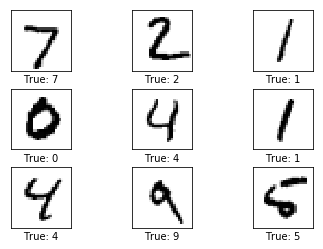

In [7]:
# Get the first images from the test-set.
images = data.test.images[:9] 
# Get the true classes for those images.
cls_true = data.test.cls[:9]  
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [8]:
######################################      Tensorflow Graph        ###############################################
# TensorFlow Graph

# The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

# TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

# TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

# A TensorFlow graph consists of the following parts which will be detailed below:

#     Placeholder variables used to change the input to the graph.
#     Model variables that are going to be optimized so as to make the model perform better.
#     The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
#     A cost measure that can be used to guide the optimization of the variables.
#     An optimization method which updates the variables of the model.

# In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

In [9]:
# Placeholder

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

In [11]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

In [12]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [14]:
cost = tf.reduce_mean(cross_entropy)

In [15]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [16]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
# TensorFlow Run

In [18]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [19]:
batch_size = 100

In [20]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)

In [21]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls:data.test.cls}

In [22]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    print("Accuracy on test-set: {0: .1%}".format(acc))

In [23]:
# Helper functions

In [38]:
def print_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()
    

In [25]:
def plot_example_errors():
    correct , cls_pred = session.run([correct_prediction, y_pred_cls],
                                     feed_dict=feed_dict_test)
    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [26]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < 10:
            image = w[:,i].reshape(img_shape)
            ax.set_xlabel("Weights: {0}".format(i))
            
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [27]:
# Result
print_accuracy()
plot_example_errors()

Accuracy on test-set:  9.8%


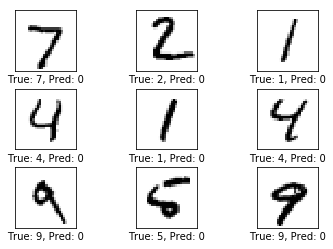

In [29]:
optimize(num_iterations=1)

Accuracy on test-set:  37.6%


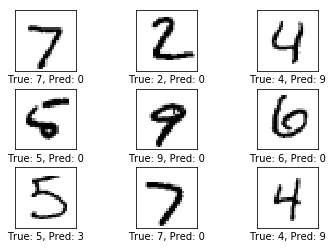

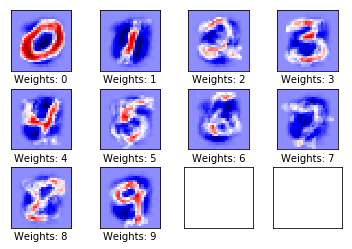

In [32]:
print_accuracy()
plot_example_errors()
plot_weights()

Accuracy on test-set:  73.3%


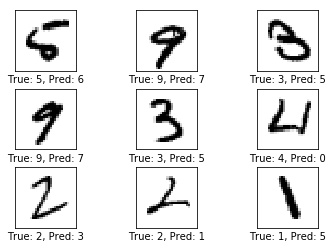

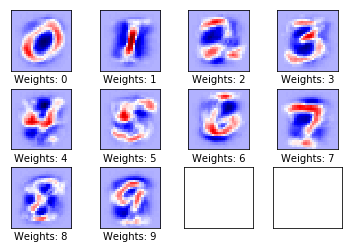

In [33]:
optimize(num_iterations=10)
print_accuracy()
plot_example_errors()
plot_weights()

Accuracy on test-set:  91.7%


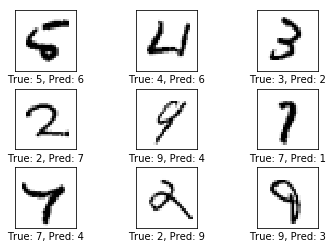

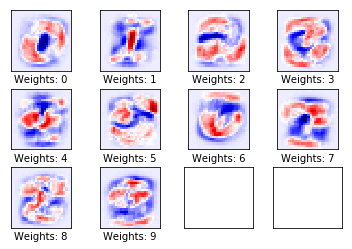

In [34]:
optimize(num_iterations=1000)
print_accuracy()
plot_example_errors()
plot_weights()

[[ 962    0    1    3    0    3    8    1    2    0]
 [   0 1115    2    2    0    1    4    2    9    0]
 [  10   12  898   28   17    2   14   11   36    4]
 [   3    1   14  947    1   17    3    9   11    4]
 [   1    1    2    2  936    1   11    2    9   17]
 [  10    5    3   54   13  748   18    7   29    5]
 [  14    3    4    2   12   11  909    1    2    0]
 [   3   13   21   15   13    1    0  933    2   27]
 [  10   14    7   39    9   19   10    9  854    3]
 [  11   11    2   13   71    8    0   22    6  865]]


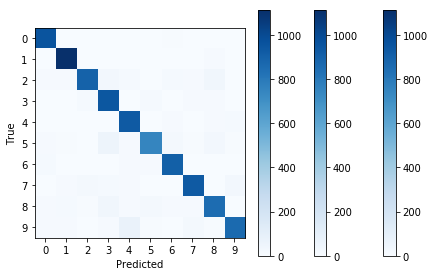

In [39]:
print_confusion_matrix()
